# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
import tqdm as tqdm
from shapely.geometry import Polygon



# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

In [2]:
# import sys
# !{sys.executable} -m pip install netcdf4

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [3]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [4]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [5]:
depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [6]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [7]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

###  This method calculates LgE and L by mascon.

In [8]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')

### Not using code below anymore!

In [21]:
# def calculate_probabilities_by_mascon(all_time_periods, earthquake_only, mascon_placement):
    
#     mascon_center_lat = mascon_placement['mascon_lat'].data
#     mascon_center_lon = mascon_placement['mascon_lon'].data
#     mascon_id = mascon_placement['mascon_id'].data
    
#     all_latitudes = all_time_periods['lat'].data
#     all_longitudes = all_time_periods['lon'].data
    
#     LgE_list = []
#     L_list = []
#     E_list = []
#     N_per_mascon = []
#     earthquake_count = 0
    
#     mascon_area_km2 = 3 * 111 * 3 * 111  # Approximate area of a 3° by 3° mascon in km²

#     for i in range(len(mascon_id)):
#             # Define approximate bounds based on a 3-degree mascon size (1.5 degrees around center)
#             lat_min = mascon_center_lat[i] - 1.5
#             lat_max = mascon_center_lat[i] + 1.5
#             lon_min = mascon_center_lon[i] - 1.5
#             lon_max = mascon_center_lon[i] + 1.5

#             # Find all earthquakes that fall within the current mascon bounds
#             earthquakes_in_mascon = earthquake_only[
#                 (earthquake_only['latitude'] >= lat_min) &
#                 (earthquake_only['latitude'] <= lat_max) &
#                 (earthquake_only['longitude'] >= lon_min) &
#                 (earthquake_only['longitude'] <= lon_max)
#             ]
            
#             if len(earthquakes_in_mascon) > 0:
#                 dmass_values = earthquakes_in_mascon['dmass']
#                 N_per_mascon = len(earthquakes_in_mascon)  # Earthquakes for the current mascon
#                 PE = N_per_mascon / mascon_area_km2  # Calculate PE for the current mascon

#                 for dmass in dmass_values:
#                     LgE_list.append(dmass)

#                     # Find the lat/lon indices for the load data
#                     lat_indices = np.where((all_latitudes >= lat_min) & (all_latitudes <= lat_max))[0]
#                     lon_indices = np.where((all_longitudes >= lon_min) & (all_longitudes <= lon_max))[0]

#                     lwe_grid = all_time_periods.isel(lat=lat_indices, lon=lon_indices).data.flatten()

#                     L_list.append(lwe_grid)
#                     earthquake_count += 1

#                     # Append PE for this particular earthquake event
#                     E_list.append(PE)

#                 print(f"Mascon {mascon_id[i]}: {len(earthquakes_in_mascon)} earthquake(s)")
    
#     print(f"Total number of earthquakes appended: {earthquake_count}")
#     return LgE_list, L_list, E_list, N_per_mascon

# LgE_list, L_list, E_list, N_per_mascon = calculate_probabilities_by_mascon(ds['lwe_thickness'], etas_declustered, mascon)

In [22]:
# def get_cp(LgE_list, L_list, E_list, method):
    
#     cp_list = []  
#     normalized_cp_list = []
    
#     bins = loadquakes.calculate_bin_sizes(LgE_list, method)
    
#     for i in range(len(LgE_list)):
#         LgE = np.array(LgE_list[i])
#         L = np.array(L_list[i])
#         E = np.array(E_list[i])

#         LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
#         L_hist = np.histogram(L, bins=bins, density=True)[0]

#         cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)
#         norm_cp = cp*E
        
#         cp_list.append(cp)
#         normalized_cp_list.append(norm_cp)

#     return bins, cp_list, normalized_cp_list  #  list of cps for all mascons that contain earthquakes

In [23]:
# def aggregate_cp(cp_list):
    
#     """
#     Aggregates the conditional probabilities from each mascon by summing them.
#     """

#     ref = len(cp_list[0])
#     aggregated_cp = np.zeros(ref)

#     # Loop through each mascon's cp and sum them up
#     for cp in cp_list:
#         if len(cp) == ref:
#             aggregated_cp += cp
#         else:
#             print('wrong size!')

#     return aggregated_cp

In [24]:
# def assign_cp(all_time_periods, earthquake_only, cp):
    
#     loads = earthquake_only.dmass
#     cp_for_each_event = []
    
#     for load in loads:
        
#         this_bin = bins[0]
#         i = 0
#         while this_bin < load:
#             if i == len(cp):
#                 break
#             else:
#                 i = i + 1
#                 this_bin = bins[i]
#         cp_for_each_event.append(cp[i-1])
        
#     return np.array(cp_for_each_event)

# Using actual mascons from JPL mascon placement file

In [13]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Convert catalog to GeoDataFrame
geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")# Handle the earthquakes by "mascon"

In [14]:
def get_cp(LgE, L, method):
    cp_list = []  
    
#     bins = loadquakes.calculate_bin_sizes(LgE, method)
    bins = np.linspace(-20,20,20)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

#     cp_list.append(cp)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

 18%|███████                                 | 798/4551 [00:09<00:42, 88.16it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 20%|████████                                | 916/4551 [00:11<01:28, 40.85it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 24%|█████████▍                             | 1104/4551 [00:14<00:50, 67.71it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 24%|█████████▌                             | 1112/4551 [00:14<01:04, 53.59it/s]/Application

20
19


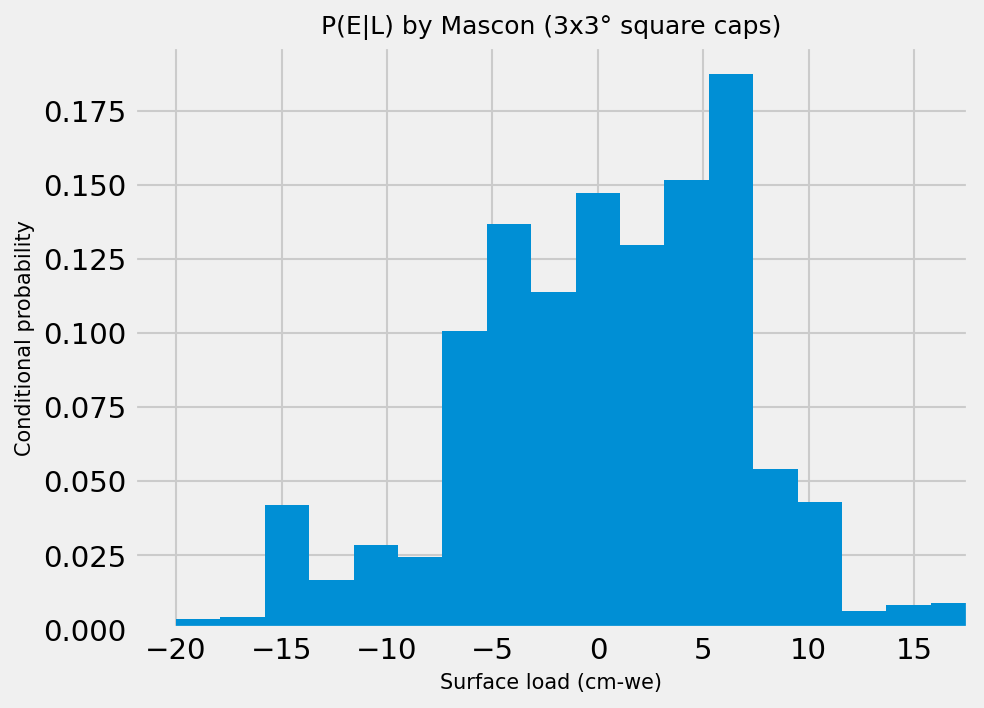

In [36]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load mascon center coordinates and IDs
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

cp = []

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf.sindex  # Builds the spatial index for faster queries

# Iterate through each mascon center
for i in tqdm(range(len(mascon_id))):
    # Define approximate bounds based on a 3-degree mascon size (1.5 degrees around center)
    lat_min = mascon_center_lat[i] - 1.5
    lat_max = mascon_center_lat[i] + 1.5
    lon_min = mascon_center_lon[i] - 1.5
    lon_max = mascon_center_lon[i] + 1.5
    
    # Clamp latitude bounds between -90 and 90
    lat_min, lat_max = max(lat_min, -90), min(lat_max, 90)
    
    # Normalize longitude bounds to [-180, 180]
    lon_min = (lon_min + 180) % 360 - 180
    lon_max = (lon_max + 180) % 360 - 180
    
    # Define bounding box polygon
    if lon_min <= lon_max:
        bbox = Polygon([
            (lon_min, lat_min), (lon_min, lat_max),
            (lon_max, lat_max), (lon_max, lat_min)
        ])
    else:
        # Handle antimeridian crossing by creating a bounding box that wraps around
        bbox = Polygon([(-180, lat_min), (-180, lat_max), (180, lat_max), (180, lat_min)])
    
    # Create GeoDataFrame for bounding box
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")
    
    # Spatial join to find earthquakes within the bounding box
    these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')
    
    # Skip to next iteration if no earthquakes
    if these_earthquakes.empty:
        continue
    
    # Retrieve load data for this mascon using the center coordinates
    # Assuming `ds` is a gridded dataset that can be indexed by lat/lon indices
    these_loads = ds.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest")['lwe_thickness'].data.flatten()
    
    # Calculate conditional probabilities
    nt = 205  # per month
    ng = (1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 510e6 / 1e5  # per 100k square km
    LgE = these_earthquakes.dmass
    L = these_loads
    E = len(these_earthquakes) / nt / ng
    
    # Compute P(E|L)
    bins, this_cp = get_cp(LgE, L, 'fd')
    this_cp = this_cp * E
    cp.append(this_cp)

# Average conditional probabilities across all mascons
cp_averaged = np.nanmean(np.array(cp), axis=0)

# Plot the averaged conditional probabilities
plt.style.use('fivethirtyeight')
wid = np.mean(np.diff(bins))

print(len(bins))
print(len(cp_averaged))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=150)

# Plot the bar chart
ax.bar(bins[:-1], cp_averaged, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon (3x3\N{DEGREE SIGN} square caps)', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

## Spherical cap version

 18%|██████▊                                | 798/4551 [00:07<00:35, 106.75it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 20%|████████                                | 916/4551 [00:09<01:09, 52.09it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 24%|█████████▍                             | 1106/4551 [00:11<00:41, 82.53it/s]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 27%|██████████▍                            | 1212/4551 [00:13<00:40, 81.51it/s]/Application

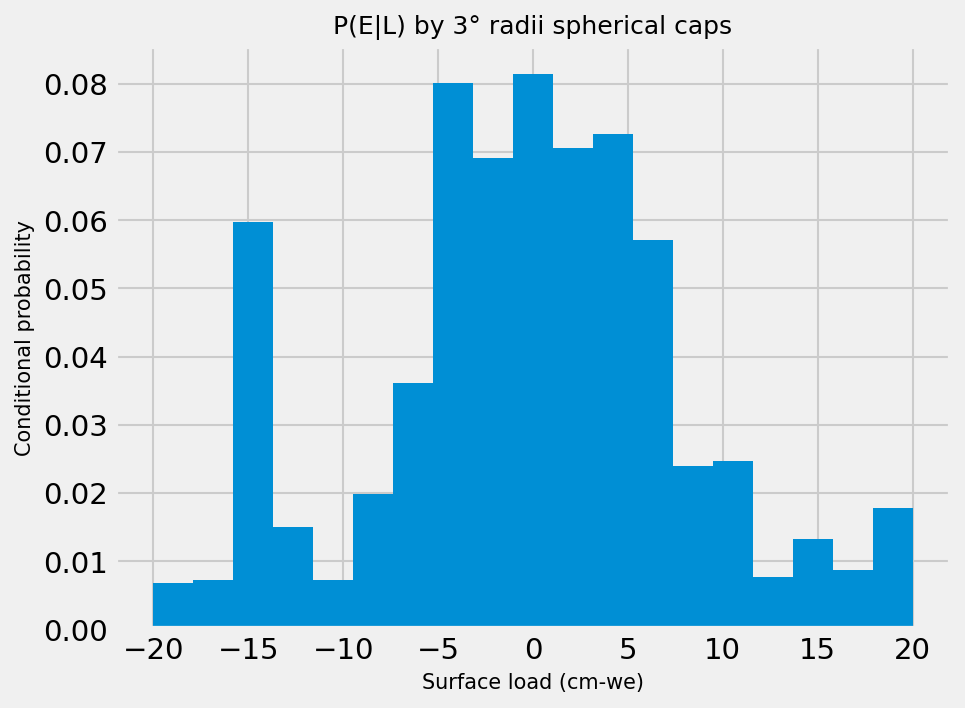

In [35]:
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data
cap_radius_deg = 1.5  # Spherical cap radius in degrees

cp = []

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf.sindex

# Iterate through each mascon center
for i in tqdm(range(len(mascon_id))):
    # Create a Point for the mascon center
    center_point = Point(mascon_center_lon[i], mascon_center_lat[i])
    
    # Define a circular buffer (spherical cap) with a 1.5-degree radius
    bbox = center_point.buffer(cap_radius_deg)
    
    # Convert the buffer to a GeoDataFrame for spatial operations
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")
    
    # Spatial join to find earthquakes within the spherical cap
    these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')
    
    # Skip to the next iteration if no earthquakes are found within this cap
    if these_earthquakes.empty:
        continue
    
    # Retrieve load data for this mascon using the center coordinates
    these_loads = ds.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest")['lwe_thickness'].data.flatten()
    
    # Calculate conditional probabilities
    nt = 205  # per month
    ng = (1 - np.cos(cap_radius_deg * np.pi / 180)) / 2 * 510e6 / 1e5  # area per 100k square km
    LgE = these_earthquakes.dmass
    L = these_loads
    E = len(these_earthquakes) / nt / ng
    
    # Compute P(E|L)
    bins, this_cp = get_cp(LgE, L, 'fd')
    this_cp = this_cp * E
    cp.append(this_cp)

# Average conditional probabilities across all mascons
cp_averaged = np.nanmean(np.array(cp), axis=0)

# Plot the averaged conditional probabilities
wid = np.mean(np.diff(bins))
plt.subplots(dpi=150)
plt.bar(bins[:-1], cp_averaged, width=wid, align='edge')
plt.xlabel('Surface load (cm-we)',fontsize=10)
plt.ylabel('Conditional probability', fontsize=10)
plt.title('P(E|L) by 3\N{DEGREE SIGN} radii spherical caps', fontsize=12)
plt.show()

In [ ]:
,